# Model Selection

## Imports

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from colorama import Fore, Style

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.neural_network import MLPClassifier


%matplotlib widget

warnings.filterwarnings("ignore")

## Load Dataset

In [2]:
df = pd.read_csv('datasets/Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
df.shape

(2200, 8)

## Scaling Features and Encoding the Target

In [4]:
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,1.068797,-0.344551,-0.101688,-0.935587,0.472666,0.043302,1.810361,rice
1,0.933329,0.140616,-0.141185,-0.759646,0.397051,0.734873,2.242058,rice
2,0.255986,0.049647,-0.081939,-0.515898,0.486954,1.771510,2.921066,rice
3,0.635298,-0.556811,-0.160933,0.172807,0.389805,0.660308,2.537048,rice
4,0.743673,-0.344551,-0.121436,-1.083647,0.454792,1.497868,2.898373,rice


In [5]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
df['label_encoded'].head()

0    20
1    20
2    20
3    20
4    20
Name: label_encoded, dtype: int64

## Train Test Split

In [6]:
df = df.sample(frac=1)
df

,N,P,K,temperature,humidity,ph,rainfall,label,label_encoded
987,-1.071605,-1.314883,-0.062190,-0.589775,0.762576,-0.092386,0.101411,pomegranate,19
1949,1.637765,-0.101968,-0.654649,-0.088501,0.396327,1.828819,-0.342873,cotton,6
1943,2.233827,-0.101968,-0.457163,0.020850,0.436452,1.421593,-0.064293,cotton,6
390,-0.827762,0.595459,-0.516409,-1.892024,-2.208112,-0.637364,0.490053,kidneybeans,9
1935,1.746140,-0.162613,-0.634901,-0.014350,0.566542,0.913013,-0.264282,cotton,6
...,...,...,...,...,...,...,...,...,...
1988,2.044171,-0.496165,-0.536157,0.046168,0.569968,0.187404,-0.481008,cotton,6
1062,1.095891,0.656105,0.135296,0.369353,0.208036,-0.332287,0.105799,banana,1
377,-0.529731,0.656105,-0.595403,-2.004574,-2.248283,-0.833941,-0.265274,kidneybeans,9
1390,1.041704,-0.860040,0.115547,-0.182229,0.632915,-0.150399,-0.991334,watermelon,21


In [7]:
x = df[features]
y = df['label_encoded']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, stratify=y)

In [9]:
x_train.shape, y_train.shape

((1320, 7), (1320,))

In [10]:
x_test.shape, y_test.shape

((880, 7), (880,))

In [11]:
y_train.value_counts()

label_encoded
20    60
16    60
6     60
1     60
2     60
10    60
15    60
7     60
14    60
3     60
11    60
13    60
4     60
12    60
19    60
21    60
0     60
17    60
18    60
9     60
5     60
8     60
Name: count, dtype: int64

## Models Traning

In [12]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=1000)
}

In [13]:
results_df = pd.DataFrame()

def evaluate_model(model, X_train, X_test, y_train, y_test, cv=5):
    """Train and evaluate a classification model, logs results into global results_df."""
    global results_df
    
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train
    
    start_pred = time.time()
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    pred_time = time.time() - start_pred
    
    if hasattr(model, "predict_proba"):
        y_test_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_test_prob = np.zeros_like(y_test_pred, dtype=float)
    
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_test_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average="weighted", zero_division=0)
    
    if len(np.unique(y_test)) > 2:
        auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr", average="weighted")
    else:
        auc = roc_auc_score(y_test, y_test_prob)
    
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy"))
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = acc
    bias = 1 - train_acc
    variance = abs(train_acc - test_acc)
    
    if train_acc > test_acc + 0.1:
        fit_status = "Overfitting"
    elif test_acc > train_acc + 0.1:
        fit_status = "Underfitting"
    else:
        fit_status = "Good Fit"
    
    cm = confusion_matrix(y_test, y_test_pred).tolist()
    
    new_row = {
        "Model": type(model).__name__,
        "Model_obj": model,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC-AUC": auc,
        "CV Score": cv_score,
        "Train Acc": train_acc,
        "Test Acc": test_acc,
        "Bias": bias,
        "Variance": variance,
        "Fit Status": fit_status,
        "Train Time": train_time,
        "Prediction Time": pred_time,
        "Confusion Matrix": cm
    }
    
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
    return new_row


In [14]:
for name, model in tqdm(models.items()):
    evaluate_model(model, x_train, x_test, y_train, y_test, cv=2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:47<00:00,  5.91s/it]


In [15]:
results_df

,Model,Model_obj,Accuracy,Precision,Recall,F1 Score,ROC-AUC,CV Score,Train Acc,Test Acc,Bias,Variance,Fit Status,Train Time,Prediction Time,Confusion Matrix
0,LogisticRegression,LogisticRegression(max_iter=1000),0.968182,0.968267,0.968182,0.967981,0.999656,0.953030,0.971970,0.968182,0.028030,0.003788,Good Fit,0.090281,0.004040,"[[40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', r...",0.997727,0.997783,0.997727,0.997727,1.000000,0.993182,1.000000,0.997727,0.000000,0.002273,Good Fit,0.528830,0.056507,"[[40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,0.985227,0.986318,0.985227,0.985398,0.999920,0.956061,1.000000,0.985227,0.000000,0.014773,Good Fit,13.860344,0.124042,"[[40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,SVC,SVC(probability=True),0.987500,0.988792,0.987500,0.987535,0.999894,0.965152,0.982576,0.987500,0.017424,0.004924,Good Fit,0.303812,0.326855,"[[40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,DecisionTreeClassifier,DecisionTreeClassifier(),0.988636,0.989207,0.988636,0.988622,0.994048,0.963636,1.000000,0.988636,0.000000,0.011364,Good Fit,0.017677,0.004552,"[[40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5,KNeighborsClassifier,KNeighborsClassifier(),0.975000,0.976659,0.975000,0.974989,0.999862,0.947727,0.977273,0.975000,0.022727,0.002273,Good Fit,0.005585,0.185205,"[[40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
6,GaussianNB,GaussianNB(),0.995455,0.995563,0.995455,0.995453,0.999992,0.991667,0.993939,0.995455,0.006061,0.001515,Good Fit,0.007204,0.008281,"[[40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
7,MLPClassifier,MLPClassifier(max_iter=1000),0.990909,0.990956,0.990909,0.990863,0.999940,0.978030,0.995455,0.990909,0.004545,0.004545,Good Fit,5.014744,0.011362,"[[40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


## Ploting roc-auc Graphs

In [16]:
def plot_roc_auc(model_name, X_test, y_test):
    model = results_df.loc[results_df['Model'] == model_name, 'Model_obj'].iloc[0]
    
    if not hasattr(model, "predict_proba"):
        raise ValueError(f"{type(model).__name__} does not support probability estimates (set probability=True for SVM).")
    
    y_prob = model.predict_proba(X_test)
        
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
        
    plt.figure(figsize=(7, 7))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (area = {roc_auc:.2f})")
        
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {type(model).__name__} (Multiclass)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

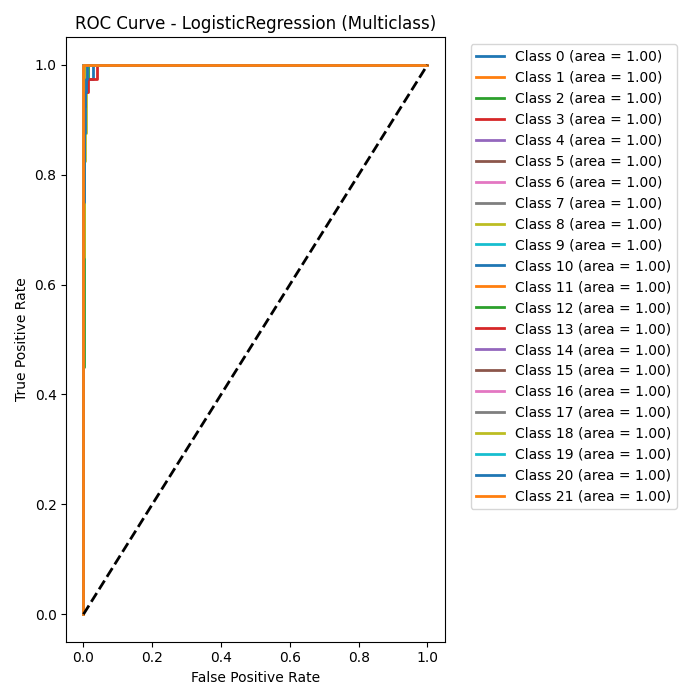

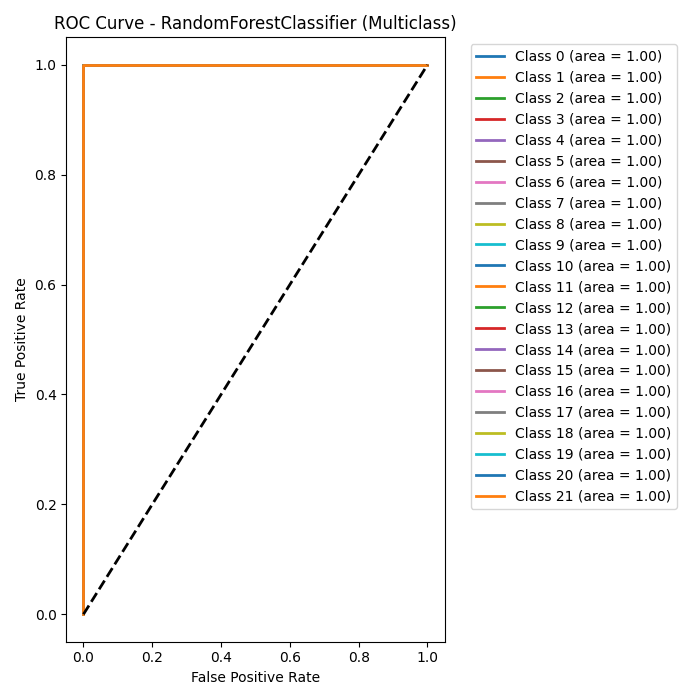

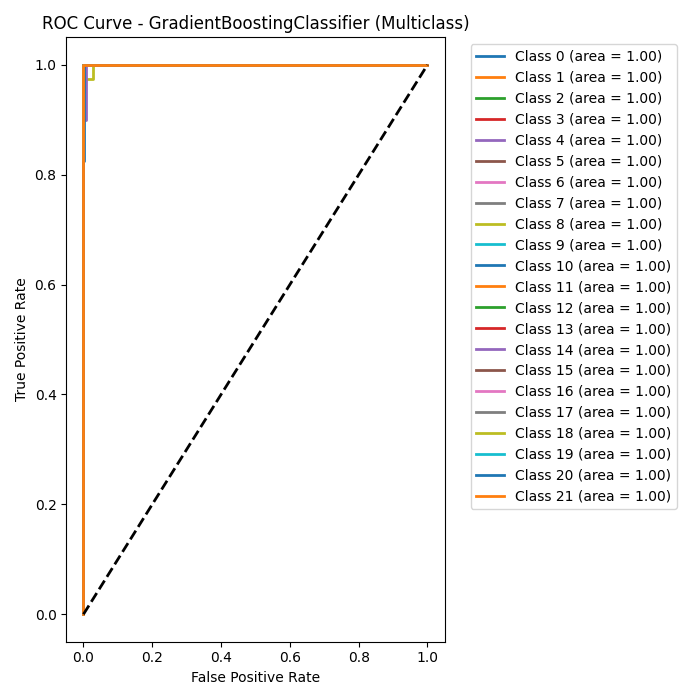

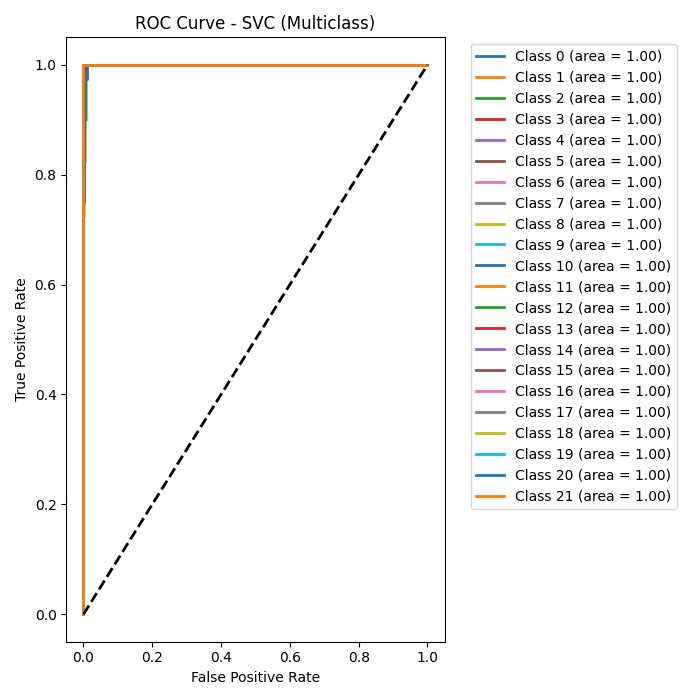

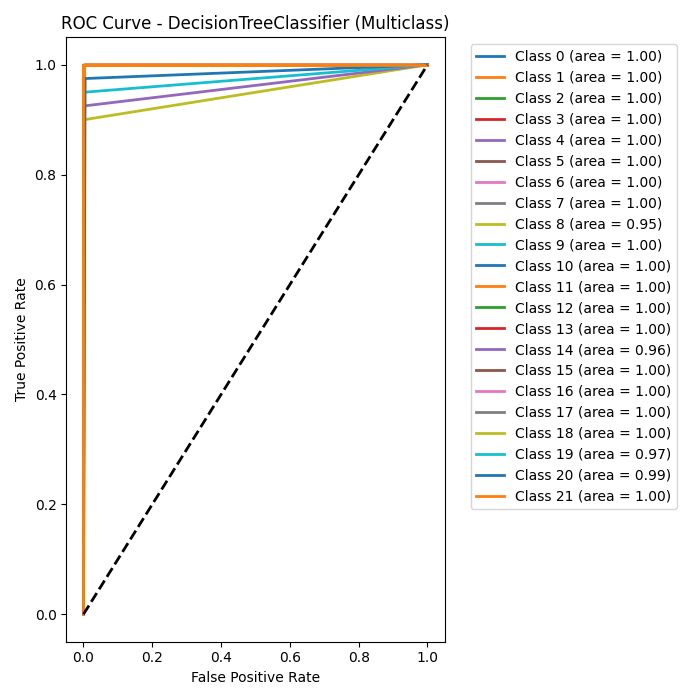

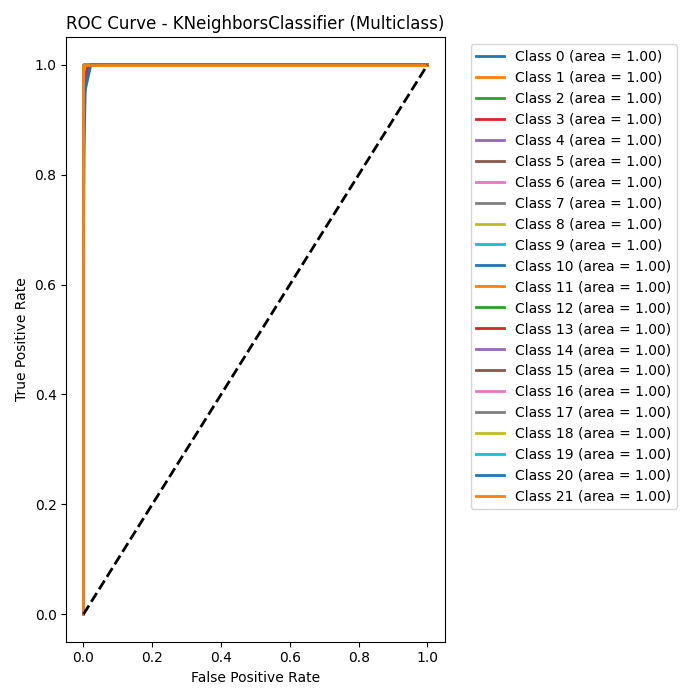

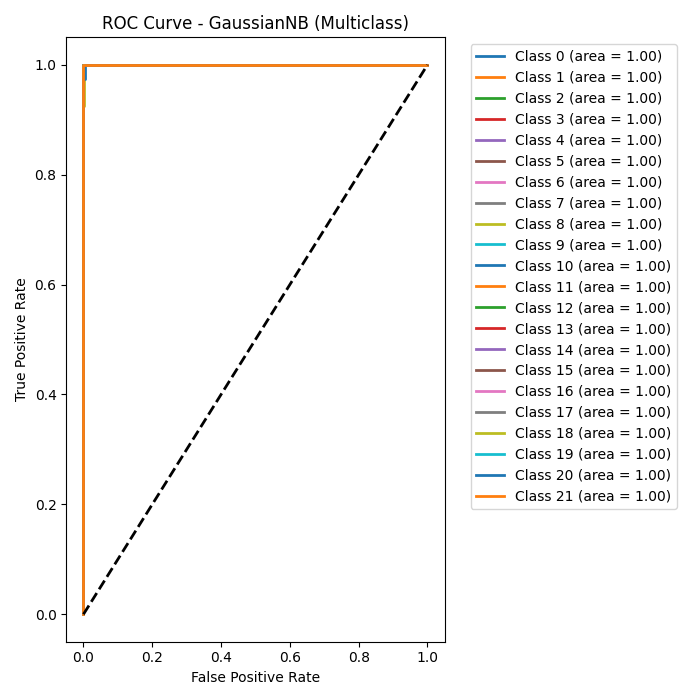

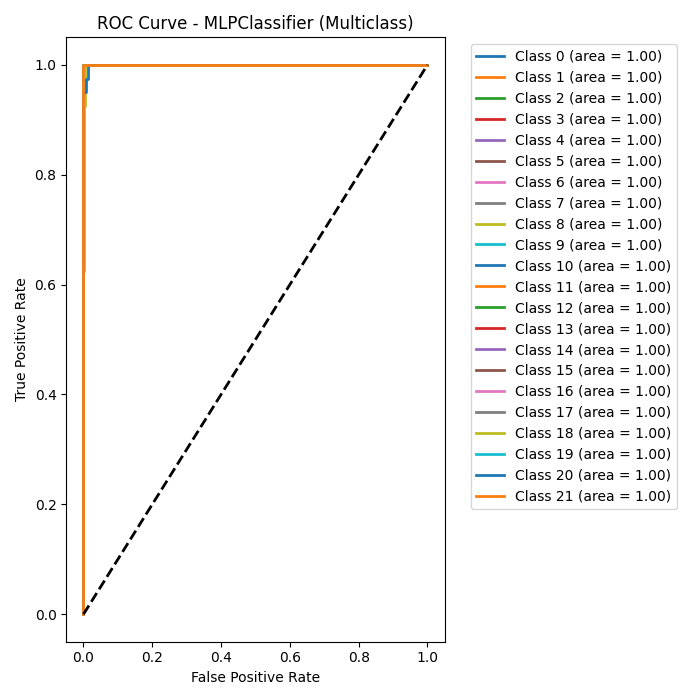

In [17]:
for name in results_df['Model'].tolist():
    plot_roc_auc(name, x_test, y_test)

## Ploting Confusion Matrix

In [18]:
def plot_confusion_matrix(model_name, class_names=[], normalize=[]):
    row = results_df.loc[results_df['Model'] == model_name].iloc[0]
    cm = row['Confusion Matrix']

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 12))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

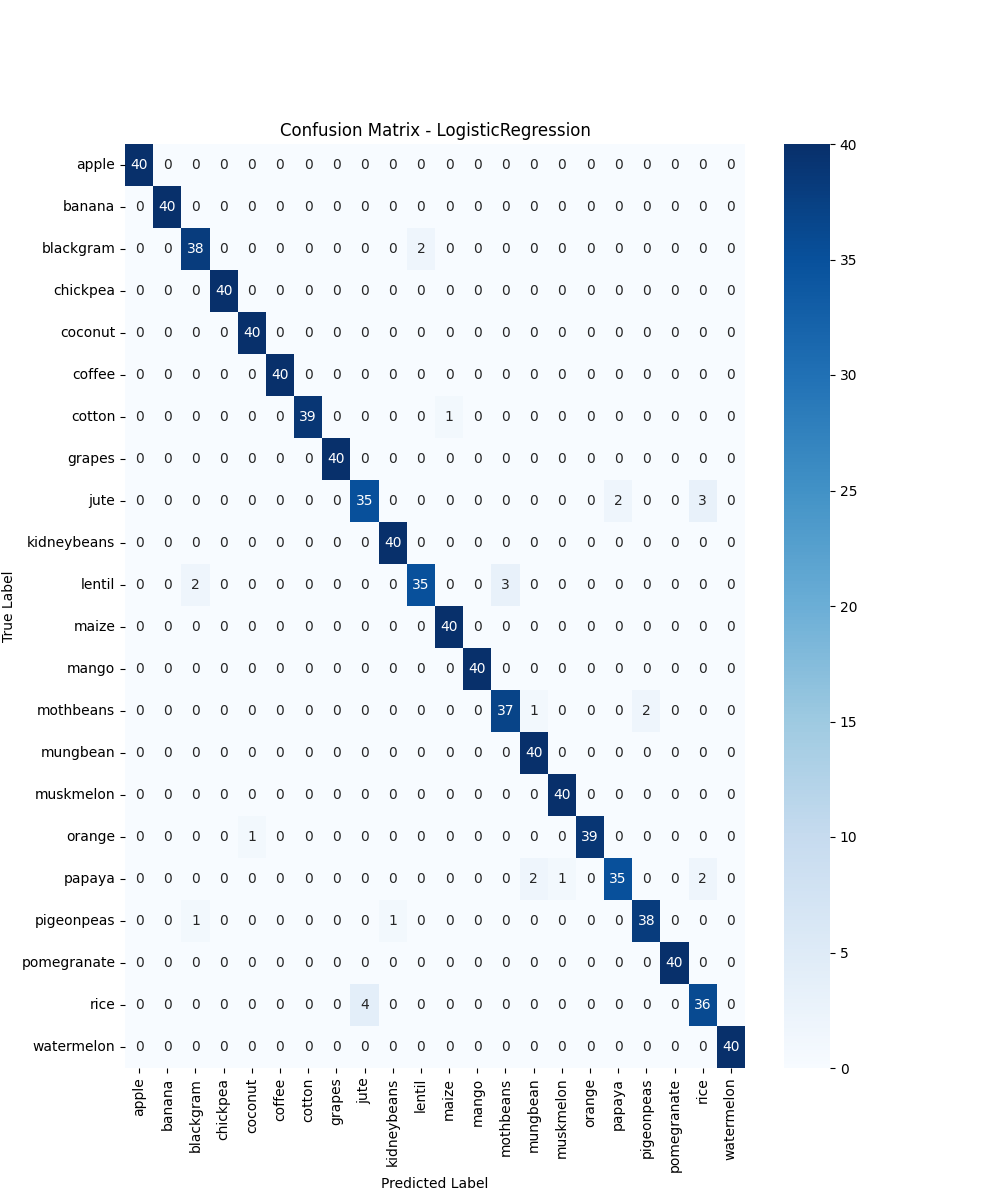

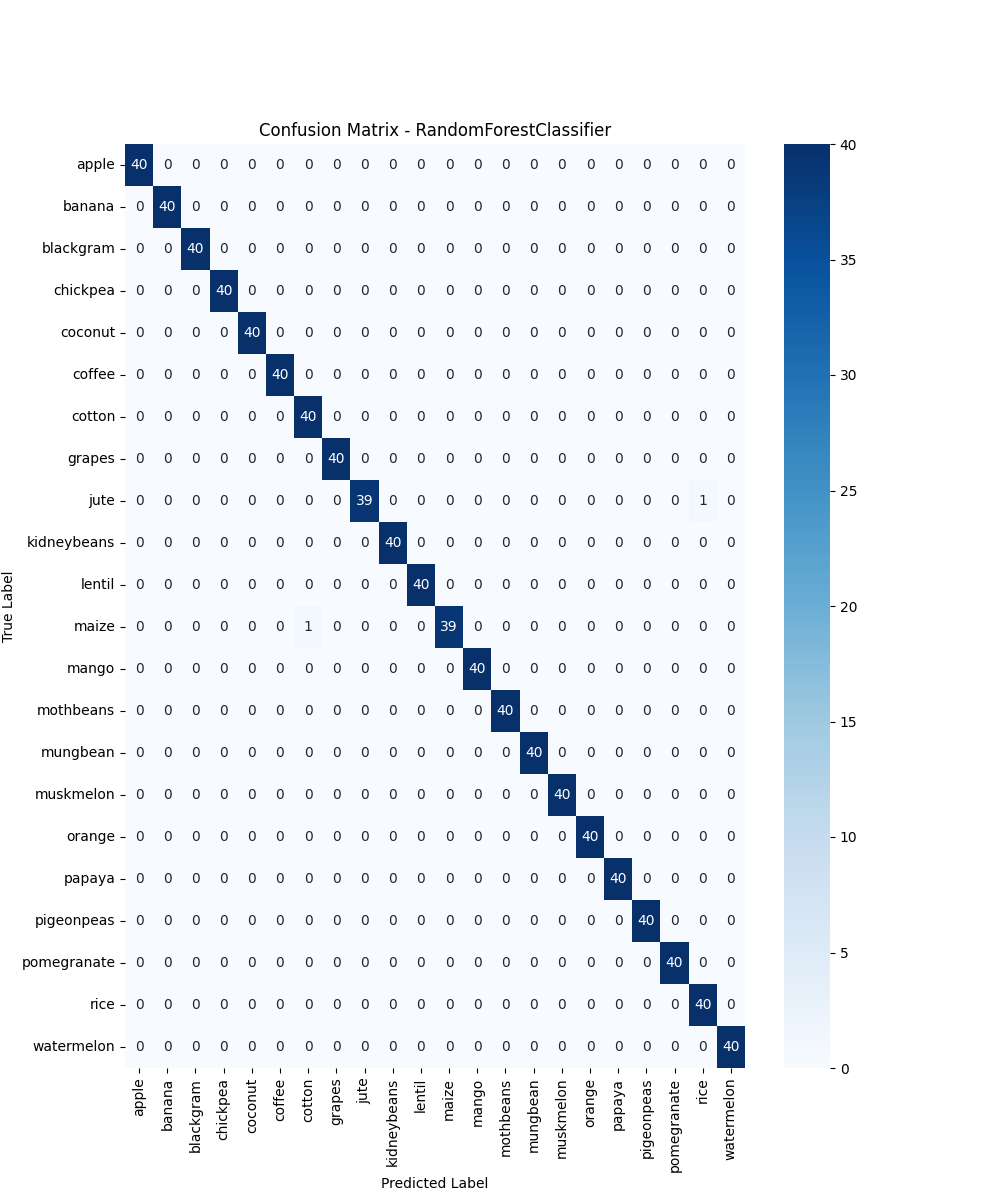

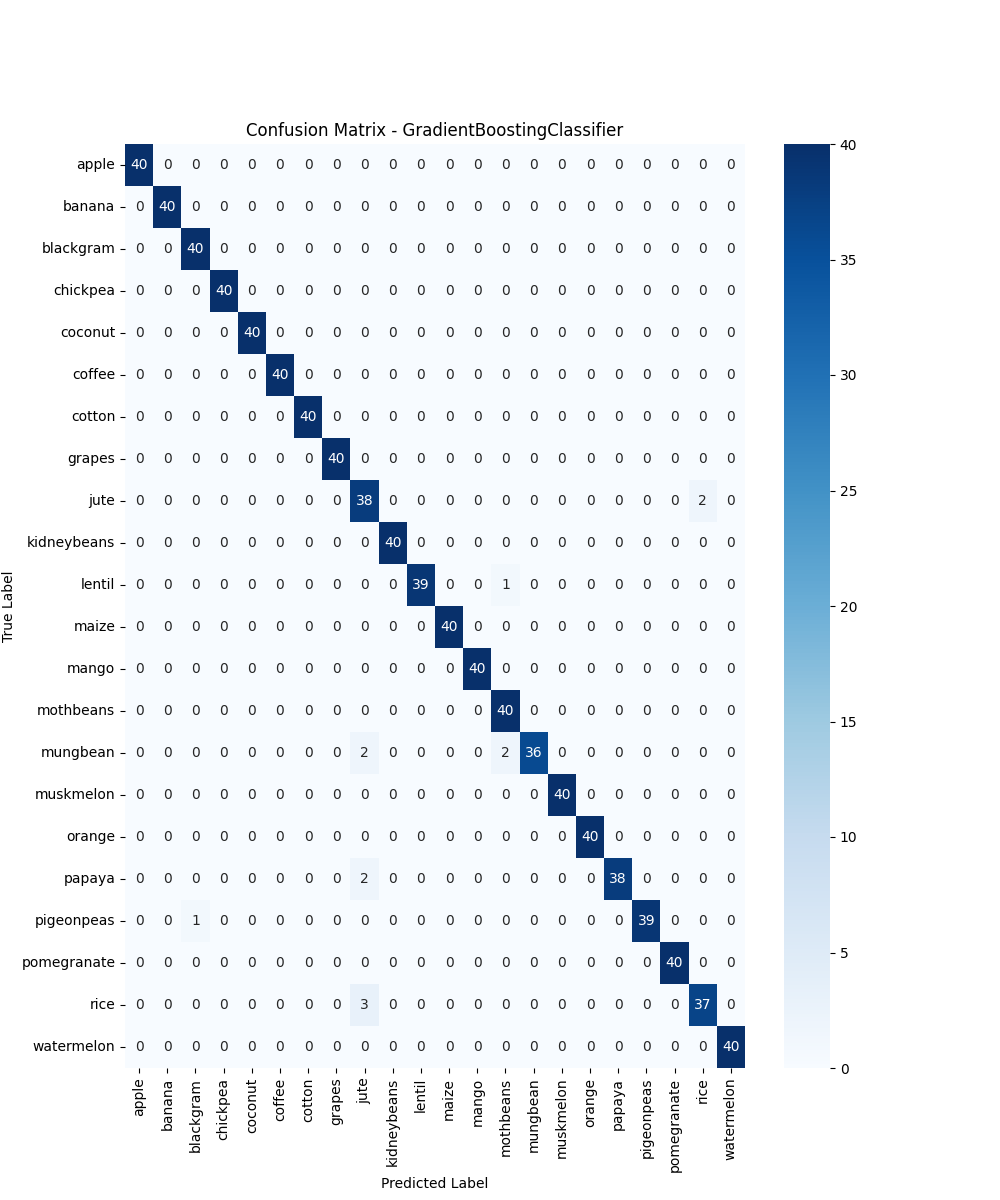

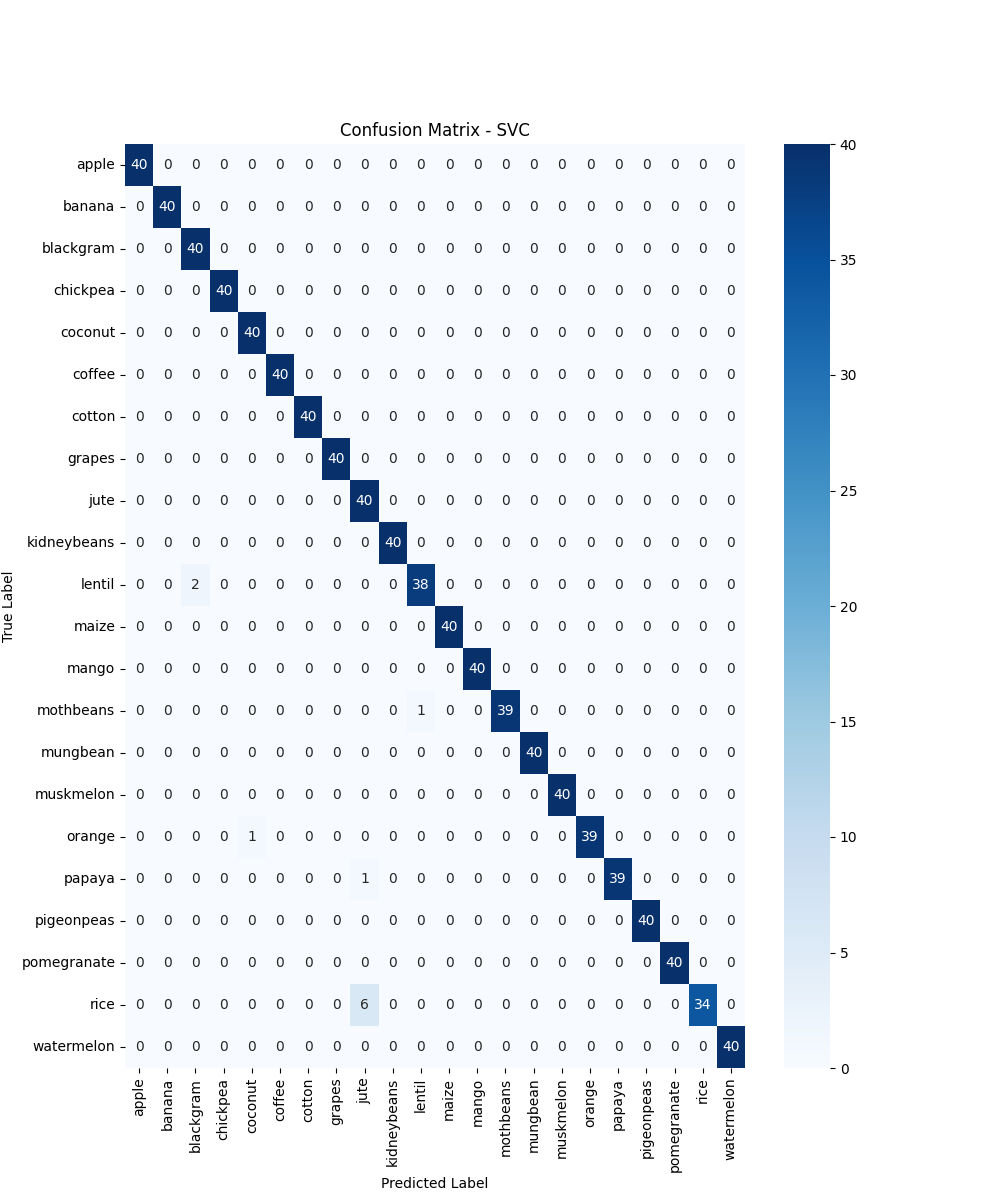

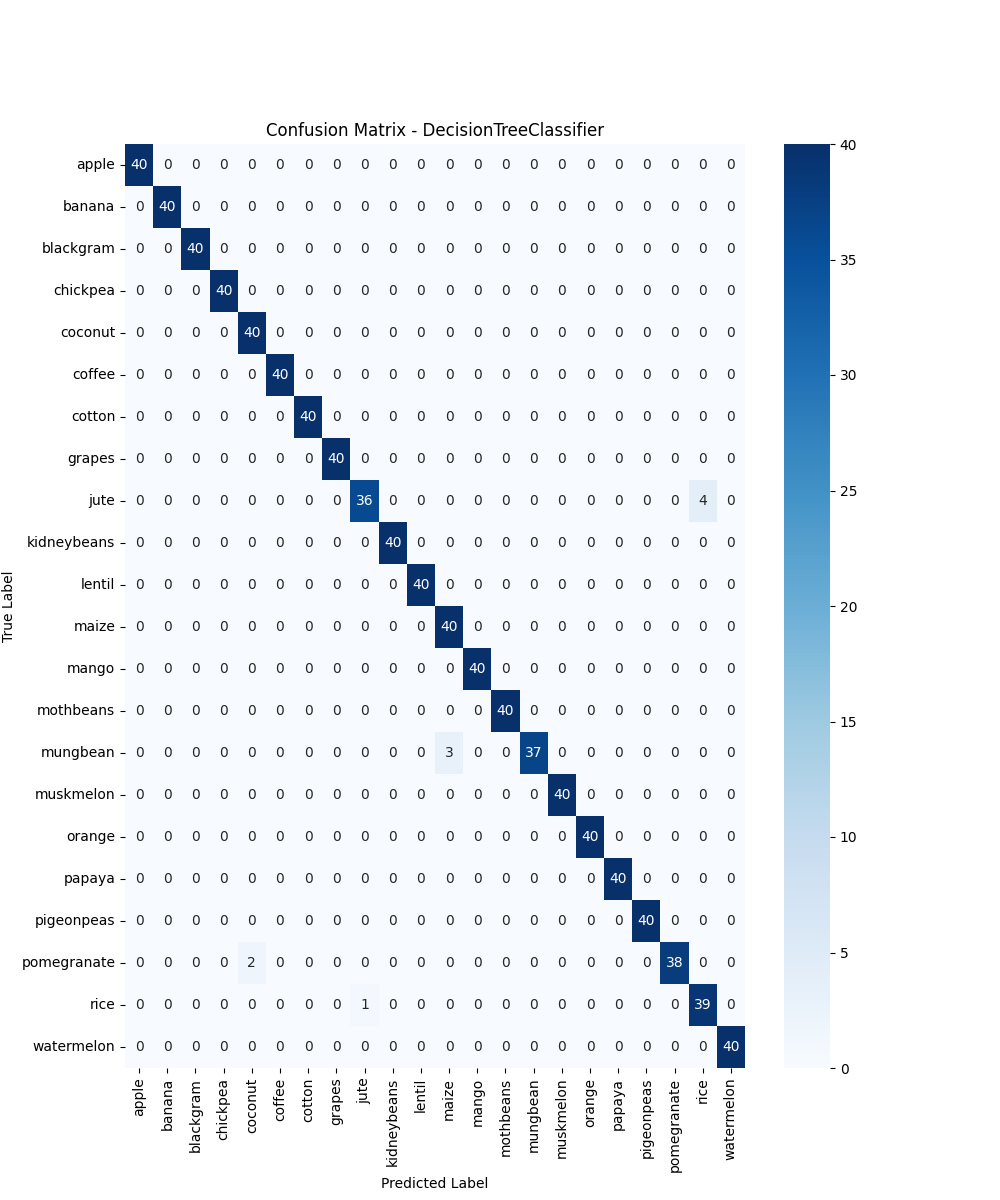

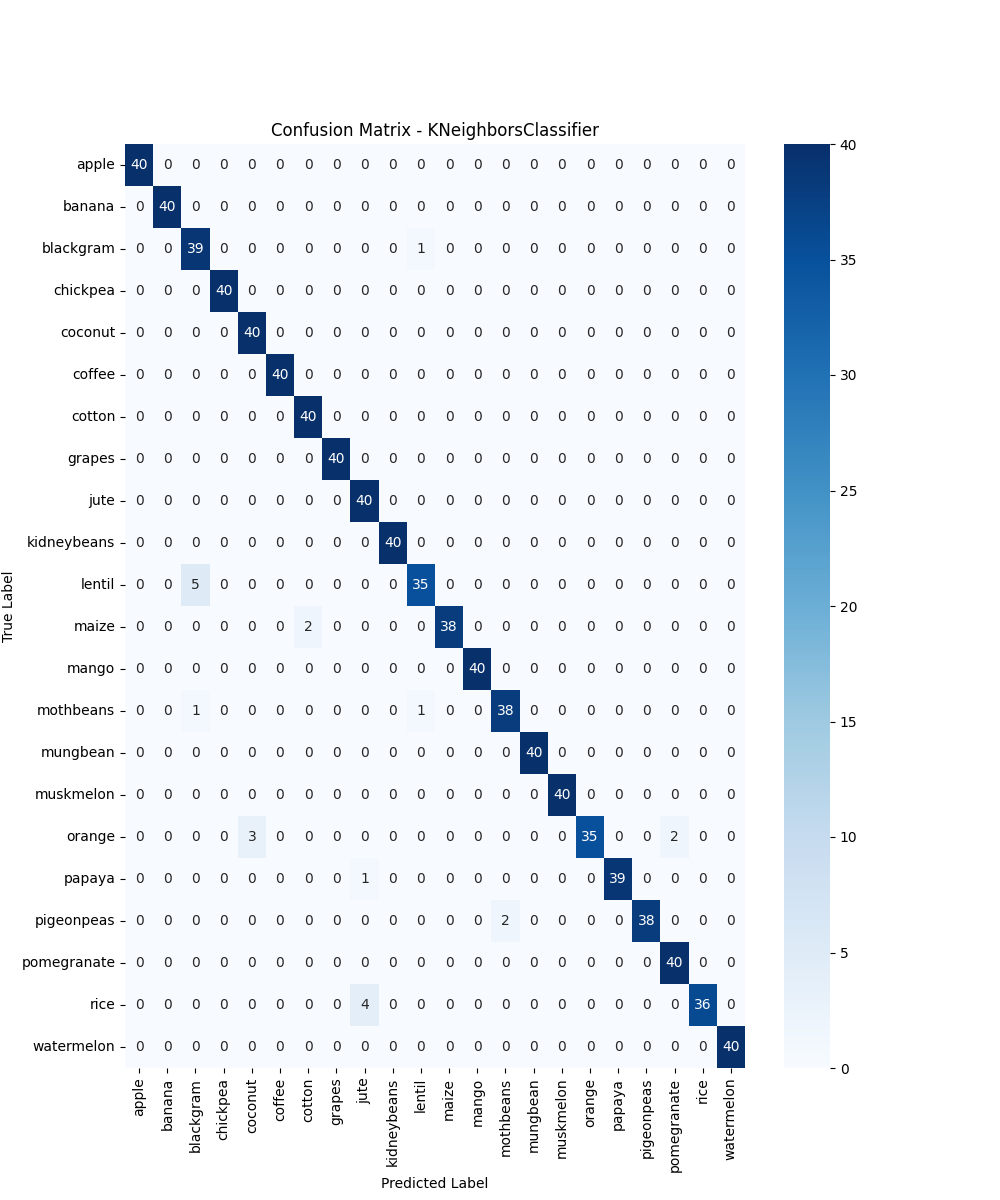

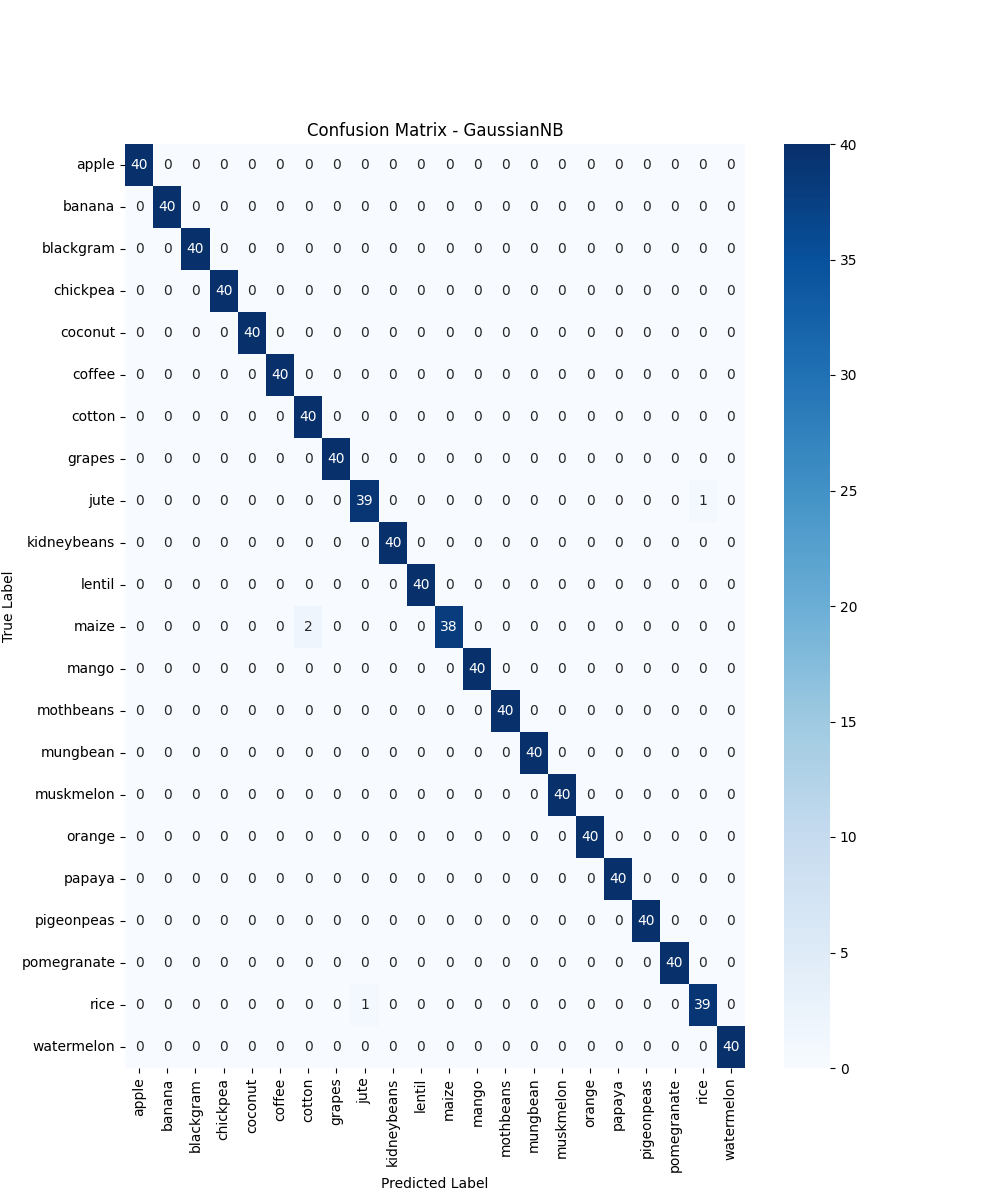

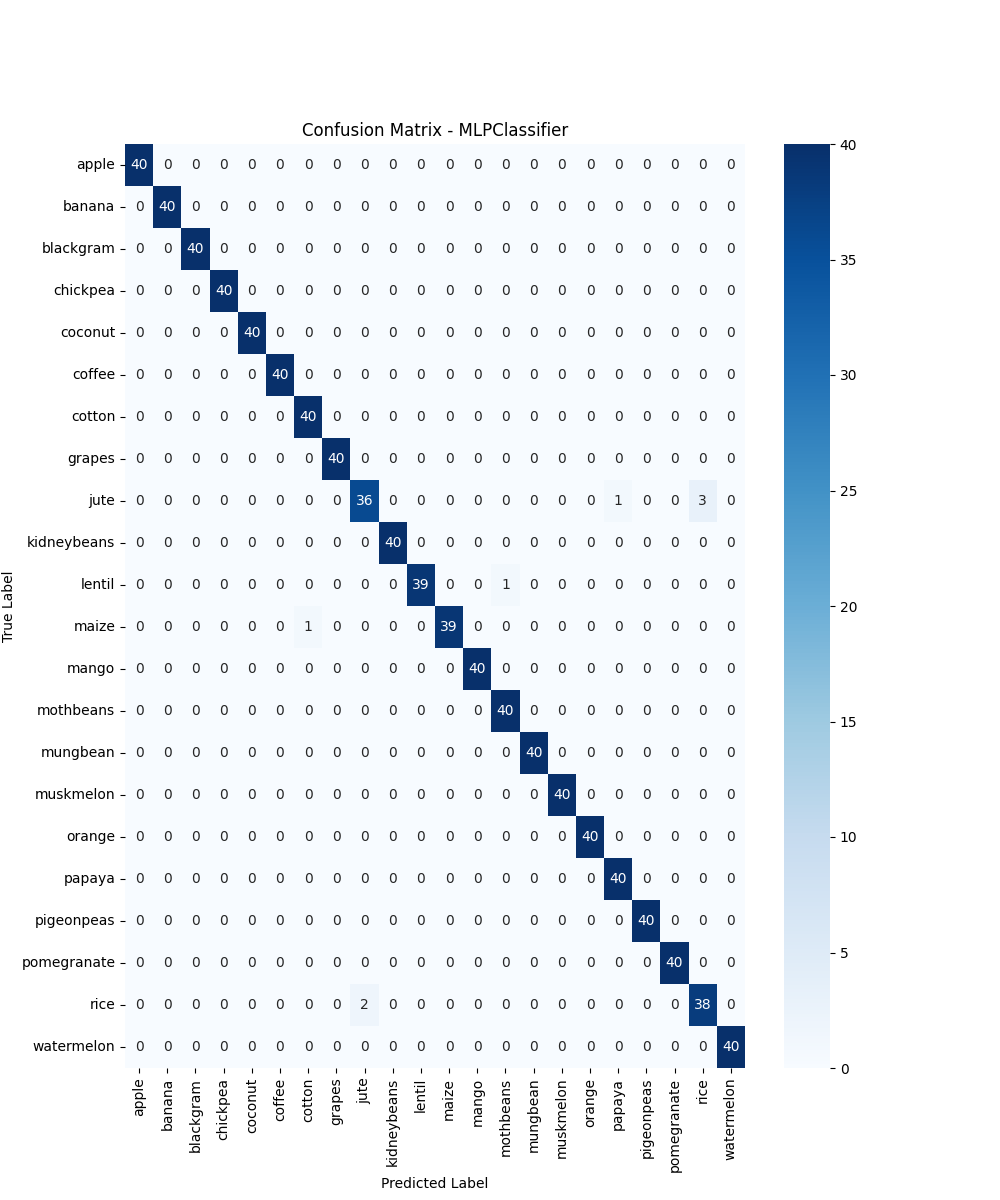

In [19]:
for name in results_df['Model'].tolist():
    plot_confusion_matrix(name, class_names=le.classes_)

## Printing Classification Reports For test and train Data

In [20]:
from colorama import Fore, Style
from sklearn.metrics import classification_report

def print_classification_report(model_name, X, y):
    model = results_df.loc[results_df['Model'] == model_name, 'Model_obj'].iloc[0]
    y_pred = model.predict(X)
    
    report = classification_report(y, y_pred, output_dict=True)
    
    # Define table header
    header = f"{'Class':<15}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'Support'}"
    
    # Center the title based on header width
    title = f"Classification Report: {model_name}"
    print(Fore.CYAN + title.center(len(header)) + Style.RESET_ALL)
    
    # Print header
    print(Fore.YELLOW + header + Style.RESET_ALL)
    
    # Helper to color numbers based on value
    def color_score(val):
        if val >= 0.9:
            return Fore.GREEN
        elif val >= 0.7:
            return Fore.YELLOW
        else:
            return Fore.RED
    
    for cls, metrics in report.items():
        if cls == "accuracy":
            label_color = Fore.MAGENTA
            num_color = color_score(metrics)
            print(
                label_color + f"{cls:<15}" +
                num_color + f"{metrics:<12.2f}" +
                Style.RESET_ALL
            )
        else:
            label_color = Fore.WHITE if cls not in ["macro avg", "weighted avg"] else Fore.MAGENTA
            print(
                label_color + f"{cls:<15}" +
                color_score(metrics['precision']) + f"{metrics['precision']:<12.2f}" +
                color_score(metrics['recall']) + f"{metrics['recall']:<12.2f}" +
                color_score(metrics['f1-score']) + f"{metrics['f1-score']:<12.2f}" +
                Fore.CYAN + f"{metrics['support']}" +
                Style.RESET_ALL
            )
    print()


In [21]:
print("============ Classification Report: Train Data ============\n")
for name in results_df['Model'].tolist():
    print_classification_report(name, x_train, y_train)

============ Classification Report: Train Data ============

        Classification Report: LogisticRegression         
Class          Precision   Recall      F1-Score    Support
0              1.00        1.00        1.00        60.0
1              1.00        1.00        1.00        60.0
2              0.92        0.95        0.93        60.0
3              1.00        1.00        1.00        60.0
4              0.98        1.00        0.99        60.0
5              0.98        1.00        0.99        60.0
6              1.00        1.00        1.00        60.0
7              1.00        1.00        1.00        60.0
8              0.83        0.95        0.88        60.0
9              0.97        0.98        0.98        60.0
10             0.93        0.93        0.93        60.0
11             1.00        1.00        1.00        60.0
12             0.98        1.00        0.99        60.0
13             0.96        0.90        0.93        60.0
14             1.00        1.00      

In [22]:
print("============ Classification Report: Test Data ============\n")
for name in results_df['Model'].tolist():
    print_classification_report(name, x_test, y_test)

============ Classification Report: Test Data ============

        Classification Report: LogisticRegression         
Class          Precision   Recall      F1-Score    Support
0              1.00        1.00        1.00        40.0
1              1.00        1.00        1.00        40.0
2              0.93        0.95        0.94        40.0
3              1.00        1.00        1.00        40.0
4              0.98        1.00        0.99        40.0
5              1.00        1.00        1.00        40.0
6              1.00        0.97        0.99        40.0
7              1.00        1.00        1.00        40.0
8              0.90        0.88        0.89        40.0
9              0.98        1.00        0.99        40.0
10             0.95        0.88        0.91        40.0
11             0.98        1.00        0.99        40.0
12             1.00        1.00        1.00        40.0
13             0.93        0.93        0.93        40.0
14             0.93        1.00       